## Experiment 1

In the first experiment, the Oxford dataset is used.
Time series data from the behavior of the 8 cells
are extracted, and the dataset is randomly split into
85% for the training set and 15% for the test set.

In [12]:
# importing libraries
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import math
import numpy as np
from scipy.ndimage import gaussian_filter1d , gaussian_filter

from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.performance_metrics.forecasting import mean_absolute_error,mean_absolute_percentage_error
from sktime.transformations.panel.padder import PaddingTransformer

In [13]:
# general parameters
len_series = 100  # the leght max of the time series

In [14]:
# Time series Extraction with label(SoH), from Oxford dataset


#import Oxford Dataset nad remove metadata
oxford_dataset = scipy.io.loadmat('dataset/Oxford/Oxford_Battery_Degradation_Dataset_1.mat', simplify_cells=True)
del oxford_dataset["__header__"]
del oxford_dataset["__version__"]
del oxford_dataset["__globals__"]


# extraction of capacity q for every battery
capacity={}          
for ox_key, ox_value in oxford_dataset.items():
    capacity[ox_key] = []
    for value in ox_value:
        last = ox_value[value]['C1ch']['q'].shape[0] - 1
        capacity[ox_key].append(ox_value[value]['C1ch']['q'][last])


# From capacity to SoH 
# SoH = q_k / q_0
y={}
for id_battery, values_battery in capacity.items():
    y[id_battery]=[]
    for key, value in enumerate(values_battery):
        y[id_battery].append(  capacity[id_battery][key] / capacity[id_battery][0] ) 


# CREO IL PANDA DATAFRAME

#Crete a dictionary with this structure: {"num ciclo _ num batteria (id)": , "voltage (v)": , "temperature (T)": }
# For every multivariate time series, there is a label (the SoH)

dict_oxford={}
for i, cell in enumerate(['Cell2','Cell3','Cell4','Cell5','Cell6','Cell7','Cell8']):

    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        
        dict_oxford[str(idch_key) + '_'+cell] = {
            'v' : pd.Series(idch_value['C1ch']['v'][:len_series]),
            'T' : pd.Series(idch_value['C1ch']['T'][:len_series]),
            'SoH' : round(y[cell][int_idch]*100)
        }
        int_idch += 1

#from dict to dataframe 
df= pd.DataFrame.from_dict(dict_oxford).transpose()
df.head()


,v,T,SoH
cyc0000_Cell2,0 2.718530 1 2.856939 2 2.878624 3...,0 40.656170 1 40.946712 2 41.00908...,100
cyc0100_Cell2,0 2.718690 1 2.852891 2 2.877542 3...,0 40.865761 1 40.909275 2 40.97164...,99
cyc0200_Cell2,0 2.719652 1 2.849444 2 2.874496 3...,0 40.760963 1 40.959179 2 40.92174...,98
cyc0300_Cell2,0 2.719667 1 2.845691 2 2.870503 3...,0 41.075390 1 40.871838 2 40.93424...,98
cyc0400_Cell2,0 2.720228 1 2.844929 2 2.869861 3...,0 40.970596 1 40.921741 2 40.95917...,97


In [15]:


# CREO IL PANDA DATAFRAME

#Crete a dictionary with this structure: {"num ciclo _ num batteria (id)": , "voltage (v)": , "temperature (T)": }
# For every multivariate time series, there is a label (the SoH)

dict_oxford_test={}
for i, cell in enumerate(['Cell1']):

    int_idch = 0
    for idch_key, idch_value in oxford_dataset[cell].items():
        
        
        dict_oxford_test[str(idch_key) + '_'+cell] = {
            'v' : pd.Series(idch_value['C1ch']['v'][:len_series]),
            'T' : pd.Series(idch_value['C1ch']['T'][:len_series]),
            'SoH' : round(y[cell][int_idch]*100)
        }
        int_idch += 1

#from dict to dataframe 
df_test= pd.DataFrame.from_dict(dict_oxford_test).transpose()
df_test.head()

,v,T,SoH
cyc0000_Cell1,0 2.719213 1 2.856135 2 2.877108 3...,0 41.295536 1 41.000046 2 40.96260...,100
cyc0100_Cell1,0 2.719614 1 2.852486 2 2.876266 3...,0 40.980995 1 40.862762 2 40.87522...,99
cyc0200_Cell1,0 2.719775 1 2.848395 2 2.872416 3...,0 41.243099 1 40.850254 2 40.80035...,98
cyc0300_Cell1,0 2.720641 1 2.844529 2 2.868671 3...,0 40.928558 1 40.887695 2 40.83778...,98
cyc0400_Cell1,0 2.720881 1 2.843206 2 2.867788 3...,0 40.823727 1 40.812817 2 40.86276...,97


In [16]:
# divide dataframe into train set e validation set

np.random.seed(2)
msk = np.random.rand(len(df)) < 0.85

x_train = df
y_train = x_train['SoH'].copy().astype('int')
x_train = x_train.drop(columns=['SoH'])

x_test = df_test
y_test = x_test['SoH'].copy().astype('int') 
x_test = x_test.drop(columns=['SoH'])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(441, 2) (441,)
(78, 2) (78,)


In [17]:

padded_clf = PaddingTransformer() * RandomIntervalClassifier(n_intervals=5, random_state=1)
padded_clf.fit(x_train, y_train)

y_pred = padded_clf.predict(x_test)




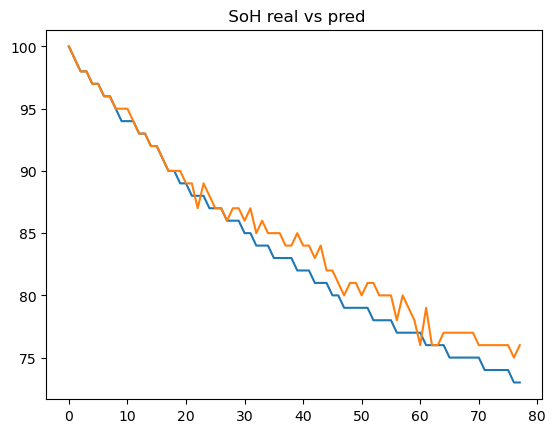

MAEP = 0.015089344228765067
MAE = 1.1923076923076923
RMSE = 1.5233229534517034


In [18]:
# plot "real vs pred" and metrics result 

MAEP = mean_absolute_percentage_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(np.square(np.subtract(y_test,y_pred)).mean())

plt.title(" SoH real vs pred")
plt.plot(y_test.values)
plt.plot( y_pred)
plt.show()

print("MAEP = " + str(MAEP))
print("MAE = " + str(MAE))
print("RMSE = " + str(RMSE))

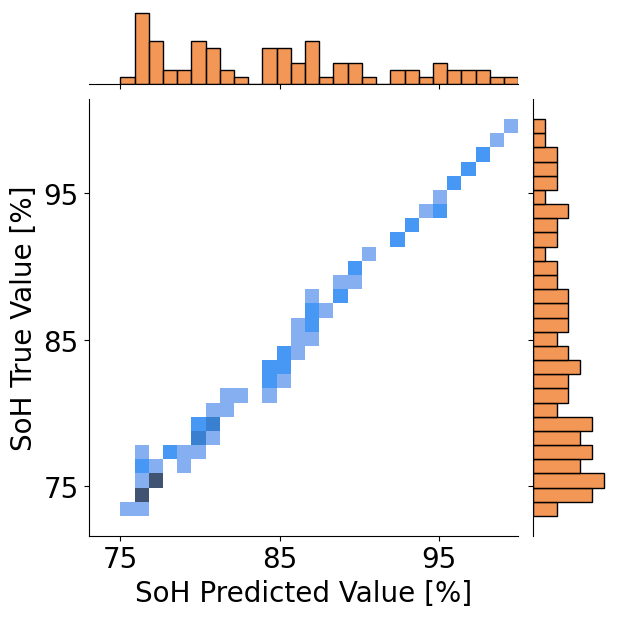

In [19]:
#PLOTTING


import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


real_pred = {
    'real':y_test.values,
    'pred':y_pred
}
df_plot = pd.DataFrame(real_pred)

colors = ["#F0741E", "#276CB3"]

class_names = np.union1d(np.unique(df_plot['real']), (np.unique(df_plot['pred'])))


g = sns.jointplot(x="pred", 
                  y="real", 
                  data=df_plot, 
                  kind="hist", 
                  marginal_kws={"color": colors[0], "bins":len(class_names)},
                  joint_kws={"color": colors[1], "bins": len(class_names)} 
                  )


g.ax_joint.tick_params(axis="both", which="major", labelsize=20)
ticks = np.arange(75, 100, 10)
labels = [f'{x}' for x in ticks]
g.ax_joint.set_xlim([min(class_names),max(class_names)])
#g.ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=3))  # Auto tick locator
#g.ax_joint.yaxis.set_major_locator(MaxNLocator(nbins=3))  #
g.ax_joint.set_yticks(ticks,labels=labels)
g.ax_joint.set_xticks(ticks,labels=labels)

g.set_axis_labels(
    'SoH Predicted Value [%]', 'SoH True Value [%]' ,fontsize=20
)

plt.savefig('plot/cell1_100_oxford_8515.png', dpi=300, bbox_inches="tight")